In [24]:
import bagpy
from bagpy import bagreader
import numpy as np
#%matplotlib
from matplotlib import pyplot as plt
from matplotlib import patches

In [25]:
# This program computes landing metrics to see how accurate the landing was,
#   and how well the landing pad stayed in the FOV
# Record a rosbag during a flight with 
#   rosbag record /re_tag_detections

# For FOV constraint metric:
# /re_tag_detections (geometry_msgs/PoseWithCovarianceStamped) contains messages:
#   header
#   pose

In [44]:
# Camera Info

# Simulation
fx = 317.0682951064176 # vert focal length in pixels
fy = 317.0682951064176 # horiz focal length in pixels
cx = 320.5 # x principal point in pixels
cy = 240.5 # y principal point in pixels
l  = 640 # length of image
w  = 480 # width of image

# Hardware
# fx =  # vert focal length in pixels
# fy =  # horiz focal length in pixels
# cx =  # x principal point in pixels
# cy =  # y principal point in pixels
# l  =  # length of image
# w  =  # width of image

In [27]:
# Load rosbag

#path = '/home/sequoyah/ROS/rosbags/'
path = '/home/sequoyah/Documents/Research/ARC_lab/VIO/rosbags/'
#path = '/filespace/w/walters/ROS/VIO_quad/rosbags/'

#bag_file = 'sim_thrust_map.bag'
#bag_file = '2023-07-21-03-51-16.bag'
bag_file_fov = 'FOV_2023-08-09-23-50-26.bag'
bag_file_no_fov = 'noFOV_2023-08-09-23-57-30.bag'

bag_fov = bagreader(path + bag_file_fov)
bag_no_fov = bagreader(path + bag_file_no_fov)
print("\nMessage types: ", bag_fov.message_types)
print("Message frequencies: ", bag_fov.frequency)

[INFO]  Data folder /home/sequoyah/Documents/Research/ARC_lab/VIO/rosbags/FOV_2023-08-09-23-50-26 already exists. Not creating.
[INFO]  Data folder /home/sequoyah/Documents/Research/ARC_lab/VIO/rosbags/noFOV_2023-08-09-23-57-30 already exists. Not creating.

Message types:  ['nav_msgs/Odometry', 'geometry_msgs/PoseStamped']
Message frequencies:  [62.50000000058975, 14.705882352944716]


In [28]:
# Convert to csv files

tag_detect_fov_csv = bag_fov.message_by_topic('/re_tag_detections')
tag_detect_no_fov_csv = bag_no_fov.message_by_topic('/re_tag_detections')
print(tag_detect_fov_csv,'\n', tag_detect_no_fov_csv)

/home/sequoyah/Documents/Research/ARC_lab/VIO/rosbags/FOV_2023-08-09-23-50-26/re_tag_detections.csv 
 /home/sequoyah/Documents/Research/ARC_lab/VIO/rosbags/noFOV_2023-08-09-23-57-30/re_tag_detections.csv


In [29]:
# Convert to numpy arrays

tag_fov_data = np.genfromtxt(tag_detect_fov_csv, delimiter=',', dtype=float, names=True)
tag_no_fov_data = np.genfromtxt(tag_detect_no_fov_csv, delimiter=',', dtype=float, names=True)

# Show field names
print(tag_fov_data.dtype.names)

('Time', 'headerseq', 'headerstampsecs', 'headerstampnsecs', 'headerframe_id', 'posepositionx', 'posepositiony', 'posepositionz', 'poseorientationx', 'poseorientationy', 'poseorientationz', 'poseorientationw')


In [30]:
# Extract data

# Times
times_fov = tag_fov_data['Time']
times_no_fov = tag_no_fov_data['Time']

# Position of landing pad wrt camera
x_fov = tag_fov_data['posepositionx']
y_fov = tag_fov_data['posepositiony']
z_fov = tag_fov_data['posepositionz']
x_no_fov = tag_no_fov_data['posepositionx']
y_no_fov = tag_no_fov_data['posepositiony']
z_no_fov = tag_no_fov_data['posepositionz']

In [31]:
# Calculate projection of landing pad on image plane (in pixels)
u_fov = cx + fx*x_fov/z_fov
v_fov = cy + fy*y_fov/z_fov
u_no_fov = cx + fx*x_no_fov/z_no_fov
v_no_fov = cy + fy*y_no_fov/z_no_fov

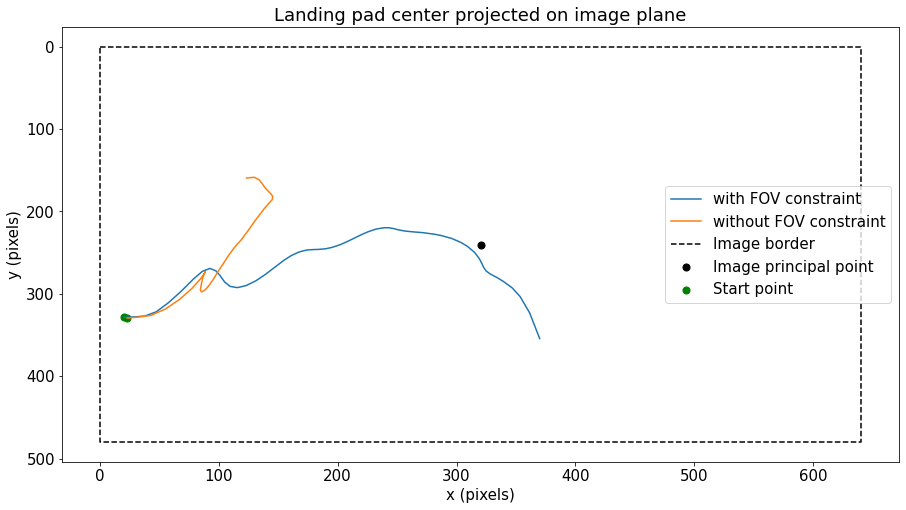

In [68]:
# Set plot params
plt.rcParams['figure.figsize'] = [15, 8]
plt.rcParams['font.size'] = 15
#print(plt.rcParams.keys)

# Plot landing pad projected on to image plane
fig, ax = plt.subplots(1)
plt.plot(u_fov, v_fov, label='with FOV constraint')
plt.plot(u_no_fov, v_no_fov, label='without FOV constraint')
ax.scatter(cx, cy, color='k', marker='o', s=50, label='Image principal point')
ax.scatter(u_fov[0], v_fov[0], color='g', marker='o', s=50, label='Start point')
ax.scatter(u_no_fov[0], v_no_fov[0], color='g', marker='o', s=50)
plt.plot([0,l,l,0,0],[0,0,w,w,0], 'k--', label='Image border')

ax.invert_yaxis()

plt.xlabel('x (pixels)')
plt.ylabel('y (pixels)')
plt.title('Landing pad center projected on image plane')
plt.legend()

plt.show()

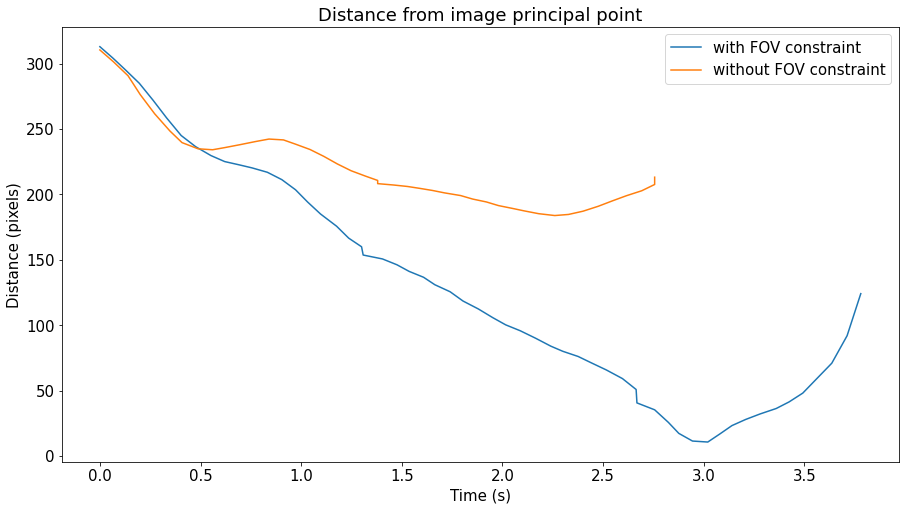

In [69]:
# Calculate distance (pixels) to image principal point
dist_fov = np.sqrt((cx - u_fov)**2 + (cy - v_fov)**2)
dist_no_fov = np.sqrt((cx - u_no_fov)**2 + (cy - v_no_fov)**2)
                    
plt.plot(times_fov - times_fov[0], dist_fov, label='with FOV constraint')
plt.plot(times_no_fov - times_no_fov[0], dist_no_fov, label='without FOV constraint')

plt.xlabel('Time (s)')
plt.ylabel('Distance (pixels)')
plt.title('Distance from image principal point')
plt.legend()

plt.show()